# **LawyerGPT**

## Importing the necessary libraries

In [ ]:
! pip install x_transformers
! pip install torchinfo
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requi

In [ ]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import os
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from datasets import Dataset

import string
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import nltk

from tokenizers import Tokenizer, decoders, normalizers, pre_tokenizers
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.normalizers import Lowercase
from tokenizers.pre_tokenizers import Whitespace, Punctuation, Digits

from x_transformers import TransformerWrapper, Encoder

import transformers
from transformers import PreTrainedTokenizerFast
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Reading the dataset

In [ ]:
# Getting the dataset chosen from Kaggle from our directory:

!gdown 18-VD4AMZl-3kht4GKlzGFZJnBPom719H

Downloading...
From: https://drive.google.com/uc?id=18-VD4AMZl-3kht4GKlzGFZJnBPom719H
To: /content/legal_text_classification.csv
100% 68.2M/68.2M [00:01<00:00, 41.5MB/s]


In [ ]:
# Printing the files in the directory to which we are connected:

print(os.getcwd())  # prints your current directory
print(os.listdir()) # lists files in the current directory

/content
['.config', 'legal_text_classification.csv', 'sample_data']


In [ ]:
# Naming the dataset:

data = pd.read_csv('/content/legal_text_classification.csv')

# Data Exploration

## Understanding the structure of data

In [ ]:
# Printing the original dataset:

data

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...
...,...,...,...,...
24980,Case25203,cited,Reches Pty Ltd v Tadiran Pty Ltd (1998) 85 FCR...,That is not confined to persons who control th...
24981,Case25204,cited,Sir Lindsay Parkinson &amp; Co Ltd v Triplan L...,Once the threshold prescribed by s 1335 is sat...
24982,Case25205,cited,Spiel v Commodity Brokers Australia Pty Ltd (I...,Once the threshold prescribed by s 1335 is sat...
24983,Case25206,distinguished,"Tullock Ltd v Walker (Unreported, Supreme Cour...",Given the extent to which Deumer stands to gai...


In [ ]:
# General info about the dataset:

data.info()  # As we can see, there are some null values in the last column.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24985 entries, 0 to 24984
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       24985 non-null  object
 1   case_outcome  24985 non-null  object
 2   case_title    24985 non-null  object
 3   case_text     24809 non-null  object
dtypes: object(4)
memory usage: 780.9+ KB


In [ ]:
data.describe()

,case_id,case_outcome,case_title,case_text
count,24985,24985,24985,24809
unique,24985,10,18581,17920
top,Case25207,cited,Minister for Immigration and Ethnic Affairs v ...,submitted that this Court should hold that the...
freq,1,12219,70,42


In [ ]:
# Selecting one row:

data.iloc[0]

,0
case_id,Case1
case_outcome,cited
case_title,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...
case_text,Ordinarily that discretion will be exercised s...


## Eliminating the non-meaningful columns

In [ ]:
# Eliminating two columns:

dataset = data.drop(['case_id', 'case_title'], axis=1)

In [ ]:
# Printing the modified dataset:

dataset

,case_outcome,case_text
0,cited,Ordinarily that discretion will be exercised s...
1,cited,The general principles governing the exercise ...
2,cited,Ordinarily that discretion will be exercised s...
3,cited,The general principles governing the exercise ...
4,cited,The preceding general principles inform the ex...
...,...,...
24980,cited,That is not confined to persons who control th...
24981,cited,Once the threshold prescribed by s 1335 is sat...
24982,cited,Once the threshold prescribed by s 1335 is sat...
24983,distinguished,Given the extent to which Deumer stands to gai...


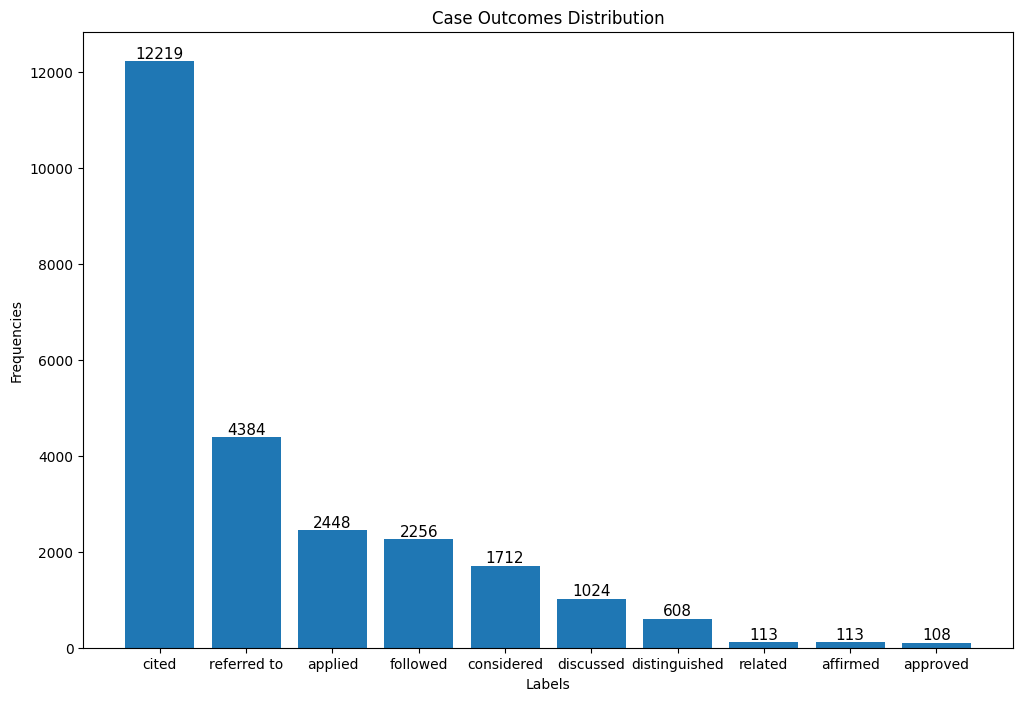

In [ ]:
# Visualizing the distribution of data within the dataset:

value_counts = dataset['case_outcome'].value_counts()  # value_counts returns a pandas series with labels as indexes and frequencies as values.


labels = value_counts.index.tolist()  # We extract the labels into a list.
values = value_counts.values.tolist()  # We extract the frequencies into a list.


plt.figure(figsize=(12, 8))  # We create a figure for a plot

bars = plt.bar(labels, values)  # We create the bars of the histogram.

for bar in bars:  # For each bar:
    h = bar.get_height()  # We get the height.
    plt.text(bar.get_x() + bar.get_width() / 2, h, str(h), ha='center', va='bottom', fontsize=11)  # We write the frequency value.

plt.title('Case Outcomes Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequencies')

plt.show()

## Data Eliminating the rows that have NULL values

In [ ]:
# Handling null values:

def null_values(dataset):

  n_null = (dataset.isnull().sum()).sum()  # Sum of null values across each row and each column.

  if n_null == 0:
    print('There are no null values in the dataset. \n')
  else:
    print(f'Before: \n\n{dataset.isnull().sum()}\n')
    dataset = dataset.dropna()  # Removal of rows with null values.
    print(f'After: \n\n{dataset.isnull().sum()}\n')
    print(f'{n_null} rows with null values have been removed.')

  return dataset

dataset = null_values(dataset)

Before: 

case_outcome      0
case_text       176
dtype: int64

After: 

case_outcome    0
case_text       0
dtype: int64

176 rows with null values have been removed.


## Reduction and balancing of the dataset

In [ ]:
# Balancing the dataset by deleting some rows:

def balance_dataset(data):

  under_labels = []
  over_labels = []

  for outcome, count in value_counts.items():
      # Selecting the labels that have less than 2000 rows
      if count < 2000:
          under_labels.append(outcome)
      # Selecting the labels that have more than 4000 rows
      elif count >= 3000:
          over_labels.append(outcome)

  print("Under-represented labels (removed):", under_labels)
  print("Over-represented labels (sampled):", over_labels)

  df = data[~data['case_outcome'].isin(under_labels)]  # Deleting the rows with the values that don't appear enough.

  # Deleting some of the rows with the values that appear too much:
  for label in over_labels:
      target_rows = df[df['case_outcome'] == label]
      rows_to_keep = target_rows.sample(n=3000, random_state=42)
      df = pd.concat([df[df['case_outcome'] != label], rows_to_keep])  # We concatenate the rows not associated with the current label, together with the rows to keep.

  # 60% of the dataset for performance reasons:
  for label in labels:
    target_rows = df[df['case_outcome'] == label]
    rows_to_keep = target_rows.sample(frac=0.5, random_state=42)
    df = pd.concat([df[df['case_outcome'] != label], rows_to_keep])

  df.reset_index(drop=True, inplace=True)  # We reset the index after having removed some rows.

  return df


dataset = balance_dataset(dataset) # We apply the function to the dataset.

Under-represented labels (removed): ['considered', 'discussed', 'distinguished', 'related', 'affirmed', 'approved']
Over-represented labels (sampled): ['cited', 'referred to']


In [ ]:
dataset

,case_outcome,case_text
0,cited,Jeffery &amp; Katauskas Pty Ltd v SST Consulti...
1,cited,Further detail concerning relevant events is g...
2,cited,The Commission contends that the fact that it ...
3,cited,"the above reasons, my conclusion is that the W..."
4,cited,grant of this form of relief in breach of conf...
...,...,...
5340,followed,"is possible, I suppose, that work as purported..."
5341,followed,Registrar accepted that while use of the Pione...
5342,followed,Counsel for Sanofi-Aventis submitted that enab...
5343,followed,"Section 477(1) requires "" actual (as opposed t..."


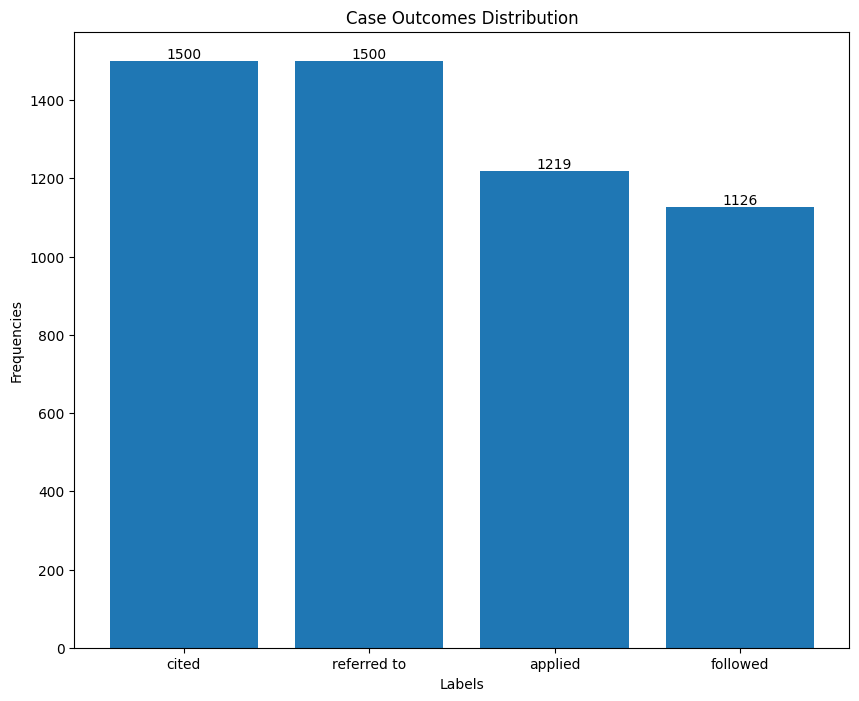

In [ ]:
# Visualizing the distribution of data after the applied changes:

value_counts = dataset['case_outcome'].value_counts()

labels = value_counts.index.tolist()
values = value_counts.values.tolist()


plt.figure(figsize=(10, 8))

bars = plt.bar(labels, values)

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, h, str(h), ha='center', va='bottom', fontsize=10)

plt.title('Case Outcomes Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequencies')

plt.show()

In [ ]:
# Checking the content of the first row

print(dataset.iloc[0]['case_text'])

Jeffery &amp; Katauskas Pty Ltd v SST Consulting Pty Ltd (2009) 260 ALR 34 at [27]-[29] French CJ, Gummow, Hayne and Crennan JJ said in respect of the prevention of abuses of process: '[27] An early statement of the power of any court to prevent abuse of its processes is found in an 1841 case, Cocker v Tempest : The power of each court over its own process is unlimited; it is a power incident to all courts, inferior as well as superior; were it not so, the court would be obliged to sit still and see its own process abused for the purpose of injustice. That statement foreshadowed the contemporary approach in the United Kingdom and Australia which takes no narrow view of what can constitute "abuse of process". Nevertheless, certain categories of conduct attracting the intervention of the courts emerged in the 19th and 20th centuries and included: (a) proceedings which involve a deception on the court, or are fictitious or constitute a mere sham; (b) proceedings where the process of the c

# Basic text cleaning

In [ ]:
# Function for the basic text cleaning:

def basic_text_cleaning(text):

    # Remove non-ASCII characters but keep legal symbols:
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # Standardize section references ("s 459C(2)(a)"):
    text = re.sub(r's\s+(\d+[A-Z]?(?:\([0-9a-zA-Z]+\))*)',
                  lambda x: f"s{x.group(1).replace(' ', '')}", text)

    # Standardize citation formats:
    # Format [YYYY] COURT NUM:
    text = re.sub(r'\[\d{4}\]\s*[A-Z]+\s*\d+',
                  lambda x: x.group().replace(' ', ''), text)
    # Format (YYYY) COURT NUM:
    text = re.sub(r'\(\d{4}\)\s*[A-Z]+\s*\d+',
                  lambda x: x.group().replace(' ', ''), text)
    # Format (YYYY) NUM REPORT NUM:
    text = re.sub(r'\(\d{4}\)\s*\d+\s*[A-Z]+\s*\d+',
                  lambda x: x.group().replace(' ', ''), text)

    # Standardize paragraph references:
    # Format at [NUM]:
    text = re.sub(r'at\s+\[\d+\]',
                  lambda x: x.group().replace(' ', ''), text)
    # Format at NUM-NUM or at NUM:
    text = re.sub(r'at\s+\d+(?:-\d+)?',
              lambda x: x.group().replace(' ', ''), text)

    # Remove URLs:
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r"www\.[A-Za-z]*\.com", '', text)

    text = text.strip()
    return text

# [^\x00-\x7F] matches any character not in the range \x00-\x7F. ^ is the negation operator. \x00-\x7F is the range of characters that are not ASCII.
# \d{4} matches a 4-digit number. \s* matches any sequence of whitespace characters. [A-Z]+ matches one or more uppercase letters. \d+ matches one or more digits. x.group() gets the entire matched string. .repace(' ', '') removes any whitespace characters from the matched string.

In [ ]:
# Applying the basic text cleaning

cleanDataset = dataset.copy()
cleanDataset['case_text'] = dataset['case_text'].apply(basic_text_cleaning)

In [ ]:
# Checking the content of the first row after the basic text cleaning

print(cleanDataset.iloc[0]['case_text'])

Jeffery &amp; Katauskas Pty Ltd v SST Consulting Pty Ltd (2009)260ALR34 at[27]-[29] French CJ, Gummow, Hayne and Crennan JJ said in respect of the prevention of abuses of process: '[27] An early statement of the power of any court to prevent abuse of its processes is found in an 1841 case, Cocker v Tempest : The power of each court over its own process is unlimited; it is a power incident to all courts, inferior as well as superior; were it not so, the court would be obliged to sit still and see its own process abused for the purpose of injustice. That statement foreshadowed the contemporary approach in the United Kingdom and Australia which takes no narrow view of what can constitute "abuse of process". Nevertheless, certain categories of conduct attracting the intervention of the courts emerged in the 19th and 20th centuries and included: (a) proceedings which involve a deception on the court, or are fictitious or constitute a mere sham; (b) proceedings where the process of the court

# Dataset Splitting

In [ ]:
# Splitting the dataset into train, validation and test sets

X_train, X_test, y_train, y_test = train_test_split(cleanDataset['case_text'], dataset['case_outcome'], test_size=0.2, random_state=42, shuffle=True, stratify=dataset['case_outcome'])

X_train.shape, X_test.shape

((4276,), (1069,))

# BPE Tokenizer

In [ ]:
# Defining the BPE tokenizer, chosen for its flexibility:

def bpe_tokenizer(data):

  texts = data.tolist()

  tokenizer = Tokenizer(BPE(unk_token='[UNK]'))

  tokenizer.normalizer = normalizers.Sequence([
    normalizers.NFKC(),  # Unicode normalization
    normalizers.Lowercase(),  # Everything lowercase.
    normalizers.Replace(r'[\s]+', ' '),  # Replaces multiple consecutive spaces with a unique whitespace.
  ])

  tokenizer.pre_tokenizer = pre_tokenizers.Sequence([

    pre_tokenizers.Whitespace(),  # Splits on whitespaces, without assinging tokens to whitespaces.
    pre_tokenizers.Digits(individual_digits=False),  # Keep numbers together instead of splitting them singularly.
    pre_tokenizers.Punctuation(),  # Splits on punctuation, assigning tokens also to punctuation.

    # Case citations:
    pre_tokenizers.Split(pattern=' v ', behavior='isolated'),  # If it encounters ' v ' pattern, it stores 'v' as token.
    pre_tokenizers.Split(pattern=' vs ', behavior='isolated'),

    # Legal roles and references:
    pre_tokenizers.Split(pattern=' J ', behavior='isolated'),
    pre_tokenizers.Split(pattern=' CJ ', behavior='isolated'),
    pre_tokenizers.Split(pattern=' JJ ', behavior='isolated'),
    pre_tokenizers.Split(pattern=' LJ ', behavior='isolated'),
    pre_tokenizers.Split(pattern=' DJ ', behavior='isolated'),

    # Common legal abbreviations:
    pre_tokenizers.Split(pattern=' et al ', behavior='isolated'),
    pre_tokenizers.Split(pattern=' etc ', behavior='isolated'),
    pre_tokenizers.Split(pattern=' i.e ', behavior='isolated'),
    pre_tokenizers.Split(pattern=' e.g ', behavior='isolated'),
    pre_tokenizers.Split(pattern=' Pty ', behavior='isolated'),
    pre_tokenizers.Split(pattern=' Ltd ', behavior='isolated'),

    # Additional legal entities
    pre_tokenizers.Split(pattern=' Inc ', behavior='isolated'),
    pre_tokenizers.Split(pattern=' Co ', behavior='isolated'),

    # Common legal document sections
    pre_tokenizers.Split(pattern=' para ', behavior='isolated'),
    pre_tokenizers.Split(pattern=' s ', behavior='isolated'),
    pre_tokenizers.Split(pattern=' reg ', behavior='isolated')
  ])

  trainer = BpeTrainer(
      vocab_size=30000,
      special_tokens=['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]'],
      min_frequency=2,
  )

  tokenizer.train_from_iterator(texts, trainer=trainer)

  return tokenizer

# Training tokenizer on train set:
tokenizer = bpe_tokenizer(X_train)

saved_tokenizer = 'tokenizer.json'
tokenizer.save(saved_tokenizer)

In [ ]:
# Tokenization example

tokenizer_trained = Tokenizer.from_file('/content/tokenizer.json')

row = X_train.iloc[0]

encoded_row = tokenizer_trained.encode(row)

print(f'Original: {row} \n')
print(f'Tokenized: {encoded_row.tokens}')

Original: general, each party to a contract agrees, by implication, to do all that is necessary on its part to enable the other party to have the benefit of the contract: Secured Income Real Estate (Australia) Ltd v St Martins Investments Pty Ltd [1979]HCA51 ; (1979)144CLR596 at607 per Mason J applying what Griffith CJ had said in Butt v M'Donald (1896)7QLJ68 at70-71. A duty to co-operate is not always implied. Whether it will be is a question of construction based on an objective consideration of the whole of the terms of the contract: Secured Income 144 CLR at607-608 per Mason J. Here, the work to refresh the Eastgardens store included the new Optus broadband display cabinet. Since Optus paid Allphones the money in order to achieve the installation of that work, it was necessary for Allphones, when exercising its contractual power to impose a reasonable charge for the work, to apply Optus' payment in reduction of the amount Hoy Mobile had to pay. I am of opinion that cll 4, 6.23 or 6

In [ ]:
pad_id = tokenizer_trained.token_to_id('[PAD]')
tokenizer_trained.enable_padding(pad_id=pad_id, pad_token="[PAD]")

fast_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer_trained)
fast_tokenizer.model_max_length = 512

vocab_size = len(fast_tokenizer)
padding_idx = fast_tokenizer.pad_token_id


def tokenize_data(texts):

  tokenized = fast_tokenizer(
      ['[CLS] ' + text for text in texts],
      truncation=True,
      padding=True)

  return {
        'input_ids': tokenized['input_ids'],
        'token_type_ids': tokenized['token_type_ids'],
        'attention_mask': tokenized['attention_mask']
    }

### Example of the tokenization on the X_train

In [ ]:
texts = X_train.values.tolist()
X_train_encoded = tokenize_data(texts)

X_train_encoded = pd.DataFrame(X_train_encoded)

In [ ]:
X_train_encoded

,input_ids,token_type_ids,attention_mask
0,"[2, 564, 16, 832, 473, 80, 38, 552, 10047, 16,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[2, 1209, 1045, 16, 1915, 1850, 11, 56, 436, 6...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[2, 2969, 80, 66, 260, 11, 56, 265, 141, 245, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"[2, 66, 1065, 75, 452, 16, 82, 73, 757, 16, 19...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[2, 67, 4066, 38, 273, 75, 1211, 2235, 16, 66,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...
4271,"[2, 978, 80, 94, 1000, 67, 2514, 106, 20951, 3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4272,"[2, 66, 413, 978, 81, 80, 531, 3726, 71, 3369,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4273,"[2, 991, 75, 66, 822, 66, 922, 75, 160, 73, 85...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4274,"[2, 46, 384, 993, 203, 379, 68, 66, 706, 92, 6...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
print(X_train.iloc[0])

general, each party to a contract agrees, by implication, to do all that is necessary on its part to enable the other party to have the benefit of the contract: Secured Income Real Estate (Australia) Ltd v St Martins Investments Pty Ltd [1979]HCA51 ; (1979)144CLR596 at607 per Mason J applying what Griffith CJ had said in Butt v M'Donald (1896)7QLJ68 at70-71. A duty to co-operate is not always implied. Whether it will be is a question of construction based on an objective consideration of the whole of the terms of the contract: Secured Income 144 CLR at607-608 per Mason J. Here, the work to refresh the Eastgardens store included the new Optus broadband display cabinet. Since Optus paid Allphones the money in order to achieve the installation of that work, it was necessary for Allphones, when exercising its contractual power to impose a reasonable charge for the work, to apply Optus' payment in reduction of the amount Hoy Mobile had to pay. I am of opinion that cll 4, 6.23 or 6.35 and th

In [ ]:
print(X_train_encoded['input_ids'][0])

[2, 564, 16, 832, 473, 80, 38, 552, 10047, 16, 129, 3776, 16, 80, 193, 229, 92, 73, 772, 68, 245, 165, 80, 2256, 66, 263, 473, 80, 211, 66, 1631, 75, 66, 552, 30, 4131, 1225, 1096, 2360, 12, 372, 13, 185, 59, 88, 11424, 1708, 236, 185, 35, 2406, 36, 307, 1095, 31, 12, 2406, 13, 3071, 312, 4457, 69, 4998, 139, 1238, 47, 2344, 531, 5265, 703, 276, 360, 67, 4991, 59, 50, 11, 4845, 12, 9340, 13, 27, 12002, 1506, 69, 1273, 17, 1845, 18, 38, 1300, 80, 175, 17, 2743, 73, 113, 2885, 1780, 18, 332, 82, 349, 94, 73, 38, 392, 75, 976, 1306, 68, 71, 2663, 866, 75, 66, 1326, 75, 66, 789, 75, 66, 552, 30, 4131, 1225, 3071, 312, 69, 4998, 17, 8302, 139, 1238, 47, 18, 1043, 16, 66, 849, 80, 13438, 66, 20687, 7712, 2337, 66, 665, 3512, 20259, 8268, 8926, 18, 1574, 3512, 1531, 4650, 66, 1924, 67, 305, 80, 3671, 66, 11865, 75, 92, 849, 16, 82, 141, 772, 106, 4650, 16, 647, 2568, 245, 2091, 645, 80, 3235, 38, 700, 2021, 106, 66, 849, 16, 80, 1015, 3512, 11, 1405, 67, 7113, 75, 66, 883, 3971, 4763, 276, 80

In [ ]:
print(tokenizer.decode(X_train_encoded['input_ids'][0]))

general , each party to a contract agrees , by implication , to do all that is necessary on its part to enable the other party to have the benefit of the contract : secured income real estate ( australia ) ltd v st martins investments pty ltd [ 1979 ] hca 51 ; ( 1979 ) 144 clr 596 at 607 per mason j applying what griffith cj had said in butt v m ' donald ( 1896 ) 7 qlj 68 at 70 - 71 . a duty to co - operate is not always implied . whether it will be is a question of construction based on an objective consideration of the whole of the terms of the contract : secured income 144 clr at 607 - 608 per mason j . here , the work to refresh the eastgardens store included the new optus broadband display cabinet . since optus paid allphones the money in order to achieve the installation of that work , it was necessary for allphones , when exercising its contractual power to impose a reasonable charge for the work , to apply optus ' payment in reduction of the amount hoy mobile had to pay . i am 

# Dataloaders

In [ ]:
# Convert to PyTorch tensors:

def convert_to_torch(df):
    return {
        'input_ids': torch.tensor(df['input_ids'].tolist(), dtype=torch.long),
        'token_type_ids': torch.tensor(df['token_type_ids'].tolist(), dtype=torch.long),
        'attention_mask': torch.tensor(df['attention_mask'].tolist(), dtype=torch.long)
    }

In [ ]:
# Training the label encoder:

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
def encodeInto_dataloader (X, y, batch_size, shuffle=True):

  # Encoding the X_set:
  texts = X.values.tolist()
  X_encoded = tokenize_data(texts)
  X_encoded = pd.DataFrame(X_encoded)

  # Converting to tensor the encoded X_set:
  X_tensor = convert_to_torch(X_encoded)

  # Checking for training or inference:
  if y is None:
        y = pd.Series([0] * len(X))

  # Converting to tensor the encoded y_set
  y_tensor = torch.tensor(y, dtype=torch.long)

  # Transforming into dataset:
  final = TensorDataset(
    X_tensor['input_ids'],
    X_tensor['token_type_ids'],
    X_tensor['attention_mask'],
    y_tensor
  )

  # Defining the Dataloader:
  dataloader = DataLoader(
      final,
      batch_size=batch_size,
      drop_last=False,
      shuffle=shuffle)

  return dataloader


# Transformer

In [ ]:
class MultiClassTransformer(nn.Module):
    def __init__(self, vocab_size, num_classes, max_seq_len, dim=512, depth=4, heads=10, emb_dropout=0.15, attn_dropout=0.1, ff_dropout=0.1):
        super().__init__()

        # Embedding layer:
        # It is created one embedding of dimension = dim for each vocab in vocab_size.
        # Input shape: (batch_size, sequence_length).
        # Output shape: (batch_size, sequence_length, dim),
        self.embedding = nn.Embedding(vocab_size, dim)

        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * (-math.log(10000.0) / dim))
        pe = torch.zeros(1, max_seq_len, dim)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pos_embedding', pe)

        # Need explicit normalization and dropout:
        # LayerNorm normalizes embeddings across the feature dimension (dim).
        # Dropout randomly zeros out elements during training with probability emb_dropout.
        self.emb_norm = nn.LayerNorm(dim)
        self.emb_dropout = nn.Dropout(emb_dropout)

        # Encoder blocks:
        # Input shape: (batch_size, sequence_length, dim).
        # Output shape: (batch_size, sequence_length, dim)
        self.encoder = Encoder(
            dim=dim,  # Input dimension for each embedding.
            depth=depth,  # Number of encoder blocks.
            heads=heads,  # Number of attention heads for each block.
            attn_dropout=attn_dropout,  # Dropout for attention
            ff_dropout=ff_dropout  # Dropout for feed-forward
        )

        # Linear layer:
        # Embedding dimension projected onto the num_classes dimension to get the logits.
        # Input shape: (batch_size, dim).
        # Output shape: (batch_size, num_classes).
        self.pre_classifier_dropout = nn.Dropout(0.1)
        self.class_head = nn.Linear(dim, num_classes)


    def forward(self, input_ids, mask):

        # Call the embedding layer manually.
        x = self.embedding(input_ids)

        # Add positional embeddings.
        x = x + self.pos_embedding[:, :x.shape[1], :]

        # Apply normalization and dropout.
        x = self.emb_norm(x)
        x = self.emb_dropout(x)

        # Process through encoder.
        bool_mask = mask.bool()  # Mask converted from dtype=long to bool.
        encoded = self.encoder(x, mask=bool_mask)

        # Get CLS embedding and projects it on the num_classes dimension.
        # For each batch, we take the first embedding (that of the CLS token) and we use it as summary of the whole sentence.
        cls_token = encoded[:, 0]
        cls_token = self.pre_classifier_dropout(cls_token)
        logits = self.class_head(cls_token)

        return logits

In [ ]:
# Set-up CPU/GPU:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Initialize the model
model = MultiClassTransformer(
    vocab_size=vocab_size,
    num_classes=len(labels),
    max_seq_len=fast_tokenizer.model_max_length
).to(device)

In [ ]:
summary(model)

Layer (type:depth-idx)                             Param #
MultiClassTransformer                              --
├─Embedding: 1-1                                   13,129,728
├─LayerNorm: 1-2                                   1,024
├─Dropout: 1-3                                     --
├─Encoder: 1-4                                     --
│    └─ModuleList: 2-1                             --
│    │    └─ModuleList: 3-1                        1,311,232
│    │    └─ModuleList: 3-2                        2,100,224
│    │    └─ModuleList: 3-3                        1,311,232
│    │    └─ModuleList: 3-4                        2,100,224
│    │    └─ModuleList: 3-5                        1,311,232
│    │    └─ModuleList: 3-6                        2,100,224
│    │    └─ModuleList: 3-7                        1,311,232
│    │    └─ModuleList: 3-8                        2,100,224
│    └─Identity: 2-2                               --
│    └─LayerNorm: 2-3                              512
│    │   

In [ ]:
class TransformerWrapper(BaseEstimator, ClassifierMixin):
  def __init__(self, vocab_size, num_classes, max_seq_len, dim=512, depth=4, heads=10, lr=2e-4, emb_dropout=0.15, batch_size=16, epochs=10):
    self.vocab_size = vocab_size
    self.num_classes = num_classes
    self.max_seq_len = max_seq_len
    self.dim = dim
    self.depth = depth
    self.heads = heads
    self.lr = lr
    self.emb_dropout = emb_dropout
    self.batch_size = batch_size
    self.epochs = epochs
    self.classes_ = None

  def fit(self, X, y):
    # Save an array with all the unique values of the labels (necessary for the GridSearch scoring)
    self.classes_ = np.unique(y)

    # Initializion the model
    self.model = MultiClassTransformer(
        vocab_size=self.vocab_size,
        num_classes=self.num_classes,
        max_seq_len=self.max_seq_len,
        dim=self.dim,
        depth=self.depth,
        heads=self.heads,
        emb_dropout=self.emb_dropout
        ).to(device)

    # Initialization of the dataloader
    train_loader = encodeInto_dataloader(X, y, self.batch_size)

    # Setting the optimization algrithm
    optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.epochs)


    # Setting the loss function
    criterion = CrossEntropyLoss().to(device)

    # Training loop
    for epoch in tqdm(range(1, self.epochs + 1)):

      self.model.train()  # Enables training mode

      for batch in train_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[2].to(device)
        labels = batch[3].to(device)

        # Forward pass
        optimizer.zero_grad()
        logits = self.model(input_ids, attention_mask)
        loss = criterion(logits, labels) # Loss calculation

        # Backpropagation pass
        loss.backward()
        optimizer.step()

      scheduler.step()

    return self

  # Predicting
  def predict(self, X):
    val_loader = encodeInto_dataloader(X, y=None, batch_size=self.batch_size, shuffle=False)
    self.model.eval() # Enable inference mode

    # Vector with all the generated labels
    predictions = []

    with torch.no_grad(): # disables the gradient calculation
      for batch in val_loader:
        input_ids = batch[0].to(device) # Extracts input
        attention_mask = batch[2].to(device) # Extracts attention mask

        logits = self.model(input_ids, attention_mask) # Calculates the logits using the extracted input and attention mask
        preds = torch.argmax(logits, dim=-1) # Does the prediction
        predictions.extend(preds.cpu().numpy()) # Adds to the predictions list all predicted values for the whole batch

    # Returning the predictions list with all the labels associated with the test set
    return predictions

# Cross validation and hyperparameter tuning

In [ ]:
# Grid with all the possible values for the different parameters
param_grid = {
    'dim': [300, 512],
    #'depth': [2, 4, 6],
    #'heads': [8, 10, 12],
    'lr': [1e-5, 5e-5, 1e-4, 5e-4]
}

# Outer and inner loop of the cross validation
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

outer_scores = []

all_best_params = []

for fold, (train_index, val_index) in enumerate(outer_cv.split(X_train, y_train)):

  print(f'Outer fold {fold + 1}/3')

  # Access the rows in the index position for the X set
  # y set is a numpy array, so it doesn't need "iloc"
  X_train_outer, y_train_outer = X_train.iloc[train_index], y_train[train_index]
  X_val_outer, y_val_outer = X_train.iloc[val_index], y_train[val_index]

  # Initialization of the model
  model = TransformerWrapper(
      vocab_size=vocab_size,
      num_classes=len(labels),
      max_seq_len=fast_tokenizer.model_max_length
  )

  # GridSearch to find the best parameters
  gs = GridSearchCV(
      estimator=model,
      param_grid=param_grid,
      scoring='accuracy',
      cv=inner_cv,
      verbose=1
  )

  # Fitting of the model
  gs.fit(X_train_outer, y_train_outer)

  # Finding the best model and parameters
  best_model = gs.best_estimator_
  best_params = gs.best_params_
  all_best_params.append(best_params)

  # Finding the accuracy score
  y_pred = best_model.predict(X_val_outer)
  outer_score = accuracy_score(y_val_outer, y_pred)
  outer_scores.append(outer_score)
  print(f"Individual fold scores: {outer_scores}")

  print(f"Best parameters for fold {fold + 1}: {best_params}")
  print(f"Fold {fold + 1} accuracy: {outer_score:.4f}")
  print("\nClassification Report:")
  print(classification_report(y_val_outer, y_pred, zero_division=0))

print("\nNested CV Results:")
print(f"Average accuracy: {np.mean(outer_scores):.4f} (+/- {np.std(outer_scores):.4f})")
print('--------------------------------------------\n')

Outer fold 1/3
Fitting 2 folds for each of 8 candidates, totalling 16 fits


100%|██████████| 10/10 [05:51<00:00, 35.10s/it]


Individual fold scores: [0.3870967741935484]
Best parameters for fold 1: {'dim': 512, 'lr': 0.0001}
Fold 1 accuracy: 0.3871

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.38      0.38       325
           1       0.38      0.36      0.37       400
           2       0.32      0.34      0.33       301
           3       0.44      0.45      0.45       400

    accuracy                           0.39      1426
   macro avg       0.38      0.38      0.38      1426
weighted avg       0.39      0.39      0.39      1426

Outer fold 2/3
Fitting 2 folds for each of 8 candidates, totalling 16 fits


100%|██████████| 10/10 [04:33<00:00, 27.35s/it]


Individual fold scores: [0.3870967741935484, 0.3775438596491228]
Best parameters for fold 2: {'dim': 300, 'lr': 0.0001}
Fold 2 accuracy: 0.3775

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.30      0.34       325
           1       0.36      0.32      0.34       400
           2       0.34      0.34      0.34       300
           3       0.40      0.53      0.46       400

    accuracy                           0.38      1425
   macro avg       0.37      0.37      0.37      1425
weighted avg       0.38      0.38      0.37      1425

Outer fold 3/3
Fitting 2 folds for each of 8 candidates, totalling 16 fits


100%|██████████| 10/10 [04:32<00:00, 27.23s/it]


Individual fold scores: [0.3870967741935484, 0.3775438596491228, 0.37894736842105264]
Best parameters for fold 3: {'dim': 300, 'lr': 0.0001}
Fold 3 accuracy: 0.3789

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.32      0.33       325
           1       0.39      0.33      0.36       400
           2       0.32      0.36      0.34       300
           3       0.45      0.49      0.47       400

    accuracy                           0.38      1425
   macro avg       0.37      0.38      0.37      1425
weighted avg       0.38      0.38      0.38      1425


Nested CV Results:
Average accuracy: 0.3812 (+/- 0.0042)
--------------------------------------------



## Training

In [ ]:
best_fold_idx = np.argmax(outer_scores)
final_best_params = all_best_params[best_fold_idx]
print(final_best_params)

# Setting the parameters to have the final best model with training
final_model = TransformerWrapper(
    vocab_size=vocab_size,
    num_classes=len(labels),
    max_seq_len=fast_tokenizer.model_max_length,
    **final_best_params,
    epochs = 30 # Epochs to train the model
)

{'dim': 512, 'lr': 0.0001}


Best parameters during cross validation: {'dim': 300, 'lr': 0.0001}

In [ ]:
# Training
final_model.fit(X_train, y_train)


100%|██████████| 30/30 [26:11<00:00, 52.37s/it]


TransformerWrapper(epochs=30, lr=0.0001, max_seq_len=512, num_classes=4,
                   vocab_size=25644)

# Evaluation

In [ ]:
y_predTest = final_model.predict(X_test)
y_predTrain = final_model.predict(X_train)

### Accuracy

In [ ]:
# Calculating the accuracy for the test set

total = len(y_test)  # Get total number of instances upfront
correct = 0

for i in range(total):
    if y_predTest[i] == y_test[i]:
        correct += 1

print(f"total instances: {total}")
print(f"correct instances: {correct}")
accuracy = correct/total
print(f"Accuracy: {accuracy}")

total instances: 1069
correct instances: 460
Accuracy: 0.4303086997193639


In [ ]:
# Calculating the accuracy for the train set

total = len(y_train)  # Get total number of instances upfront
correct = 0
for i in range(total):
    if y_predTrain[i] == y_train[i]:
        correct += 1

print(f"total instances: {total}")
print(f"correct instances: {correct}")
accuracy = correct/total
print(f"Accuracy: {accuracy}")

total instances: 4276
correct instances: 4189
Accuracy: 0.9796538821328344


### Precision

In [ ]:
# Calculate Precision score for the test set

precision_micro_test = precision_score(y_test, y_predTest, average='micro')
precision_macro_test = precision_score(y_test, y_predTest, average='macro')
precision_weighted_test = precision_score(y_test, y_predTest, average='weighted')

print(f"Precision Score (Micro): {precision_micro_test}")
print(f"Precision Score (Macro): {precision_macro_test}")
print(f"Precision Score (Weighted): {precision_weighted_test}")

Precision Score (Micro): 0.4303086997193639
Precision Score (Macro): 0.4247610410511502
Precision Score (Weighted): 0.42899504781752223


In [ ]:
# Calculate Precision score for the train set

precision_micro_train = f1_score(y_train, y_predTrain, average='micro')
precision_macro_train = f1_score(y_train, y_predTrain, average='macro')
precision_weighted_train = f1_score(y_train, y_predTrain, average='weighted')

print(f"Precision Score (Micro): {precision_micro_train}")
print(f"Precision Score (Macro): {precision_macro_train}")
print(f"Precision Score (Weighted): {precision_weighted_train}")

Precision Score (Micro): 0.9796538821328344
Precision Score (Macro): 0.9792780358600057
Precision Score (Weighted): 0.9796431643069642


### Recall

In [ ]:
# Calculate Recall score for the test set

recall_micro_test = recall_score(y_test, y_predTest, average='micro')
recall_macro_test = recall_score(y_test, y_predTest, average='macro')
recall_weighted_test = recall_score(y_test, y_predTest, average='weighted')

print(f"Recall Score (Micro): {recall_micro_test}")
print(f"Recall Score (Macro): {recall_macro_test}")
print(f"Recall Score (Weighted): {recall_weighted_test}")

Recall Score (Micro): 0.4303086997193639
Recall Score (Macro): 0.42478142076502734
Recall Score (Weighted): 0.4303086997193639


In [ ]:
recall_micro_train = recall_score(y_train, y_predTrain, average='micro')
recall_macro_train = recall_score(y_train, y_predTrain, average='macro')
recall_weighted_train = recall_score(y_train, y_predTrain, average='weighted')

print(f"Recall Score (Micro): {recall_micro_train}")
print(f"Recall Score (Macro): {recall_macro_train}")
print(f"Recall Score (Weighted): {recall_weighted_train}")

Recall Score (Micro): 0.9796538821328344
Recall Score (Macro): 0.9791731409544949
Recall Score (Weighted): 0.9796538821328344


### F1-score

In [ ]:
# Calculate F1 score for the test set

f1_micro_test = f1_score(y_test, y_predTest, average='micro')
f1_macro_test = f1_score(y_test, y_predTest, average='macro')
f1_weighted_test = f1_score(y_test, y_predTest, average='weighted')

print(f"F1 Score (Micro): {f1_micro_test}")
print(f"F1 Score (Macro): {f1_macro_test}")
print(f"F1 Score (Weighted): {f1_weighted_test}")

F1 Score (Micro): 0.4303086997193639
F1 Score (Macro): 0.4246605915360818
F1 Score (Weighted): 0.4295424570018966


In [ ]:
# Calculate F1 score for the train set

f1_micro_train = f1_score(y_train, y_predTrain, average='micro')
f1_macro_train = f1_score(y_train, y_predTrain, average='macro')
f1_weighted_train = f1_score(y_train, y_predTrain, average='weighted')

print(f"F1 Score (Micro): {f1_micro_train}")
print(f"F1 Score (Macro): {f1_macro_train}")
print(f"F1 Score (Weighted): {f1_weighted_train}")

F1 Score (Micro): 0.9796538821328344
F1 Score (Macro): 0.9792780358600057
F1 Score (Weighted): 0.9796431643069642


### Checking overfitting over the f1 metric

The f1-score is the most adeguate score for evaluating our model, because the dataset is unbalanced

In [ ]:
# Evaluating overfitting

OverfittingOn_f1_micro = abs(f1_micro_test - f1_micro_train)
OverfittingOn_f1_macro = abs(f1_macro_test - f1_macro_train)
OverfittingOn_f1_weighted = abs(f1_weighted_test - f1_weighted_train)

print(f"Overfitting (Micro f1-score): {OverfittingOn_f1_micro}")
print(f"Overfitting (Macro f1-score): {OverfittingOn_f1_macro}")
print(f"Overfitting (Weighted f1-score): {OverfittingOn_f1_weighted }")

Overfitting (Micro f1-score): 0.5493451824134705
Overfitting (Macro f1-score): 0.5546174443239239
Overfitting (Weighted f1-score): 0.5501007073050677


### Confusion matrix

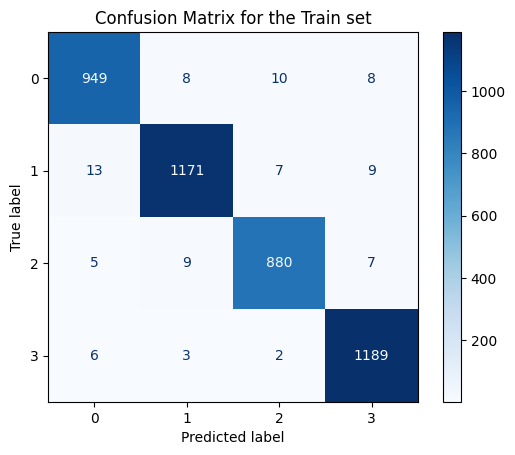

In [ ]:
# Generate confusion matrix the Train set
cm = confusion_matrix(y_train, y_predTrain)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for the Train set")
plt.show()

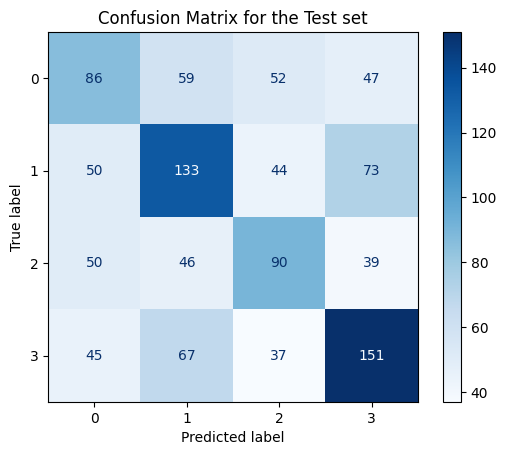

In [ ]:
# Generate confusion matrix for the Test set
cm = confusion_matrix(y_test, y_predTest)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for the Test set")
plt.show()

## PreTrained Model Comparison

In [ ]:
model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# First split into train and test:
X_train, X_test, y_train, y_test = train_test_split(
    cleanDataset['case_text'],
    cleanDataset['case_outcome'],
    test_size=0.2,
    random_state=1,
    shuffle=True,
    stratify=cleanDataset['case_outcome']
)

# Encode labels:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Then split train into train and validation:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=1,
    shuffle=True,
    stratify=y_train
)

# Create DataFrames back:
train_df = pd.DataFrame({
    'case_text': X_train,
    'case_outcome': y_train
})

val_df = pd.DataFrame({
    'case_text': X_val,
    'case_outcome': y_val
})

test_df = pd.DataFrame({
    'case_text': X_test,
    'case_outcome': y_test
})

# Convert to HF datasets:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenize function:
def tokenize_function(X):
    tokenized = tokenizer(X['case_text'], padding='max_length', truncation=True, max_length=512)
    tokenized['labels'] = X['case_outcome']
    return tokenized

# Apply tokenization:
train_encoded = train_dataset.map(tokenize_function, batched=True, batch_size=None)
val_encoded = val_dataset.map(tokenize_function, batched=True, batch_size=None)
test_encoded = test_dataset.map(tokenize_function, batched=True, batch_size=None)

Map:   0%|          | 0/3848 [00:00<?, ? examples/s]

Map:   0%|          | 0/428 [00:00<?, ? examples/s]

Map:   0%|          | 0/1069 [00:00<?, ? examples/s]

In [ ]:
# Return a dictionary of evaluation metrics
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, support = precision_recall_fscore_support(labels, preds, average='weighted', zero_division = 0)
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Getting the number of unique labels
num_labels = len(label_encoder.classes_)

# Model initialization
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

# Setting the training arguments
training_args = TrainingArguments(
    output_dir = "./results",
    report_to="none",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)

# Initialization of training object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_encoded,
    eval_dataset=val_encoded,
    compute_metrics=compute_metrics,
)

# Training of the model
trainer.train()

# Test set evaluation
test_results = trainer.evaluate(test_encoded)
print("\nTest set results:")
print(test_results)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.330019,0.359813,0.302984,0.453440,0.359813
2,No log,1.315711,0.350467,0.306922,0.395816,0.350467
3,1.325300,1.317649,0.427570,0.419224,0.425609,0.427570
4,1.325300,1.368218,0.408879,0.398295,0.413250,0.408879
5,1.019700,1.451076,0.441589,0.437579,0.439021,0.441589
6,1.019700,1.695514,0.441589,0.430541,0.453191,0.441589
7,0.575400,1.861595,0.446262,0.440089,0.462618,0.446262
8,0.575400,1.956876,0.439252,0.437597,0.454032,0.439252
9,0.300200,2.291768,0.439252,0.424856,0.482099,0.439252
10,0.300200,2.417999,0.439252,0.430270,0.454892,0.439252



Test set results:
{'eval_loss': 3.8044745922088623, 'eval_accuracy': 0.44808231992516373, 'eval_f1': 0.4489189846281829, 'eval_precision': 0.45642580555565115, 'eval_recall': 0.44808231992516373, 'eval_runtime': 7.9865, 'eval_samples_per_second': 133.85, 'eval_steps_per_second': 8.389, 'epoch': 30.0}


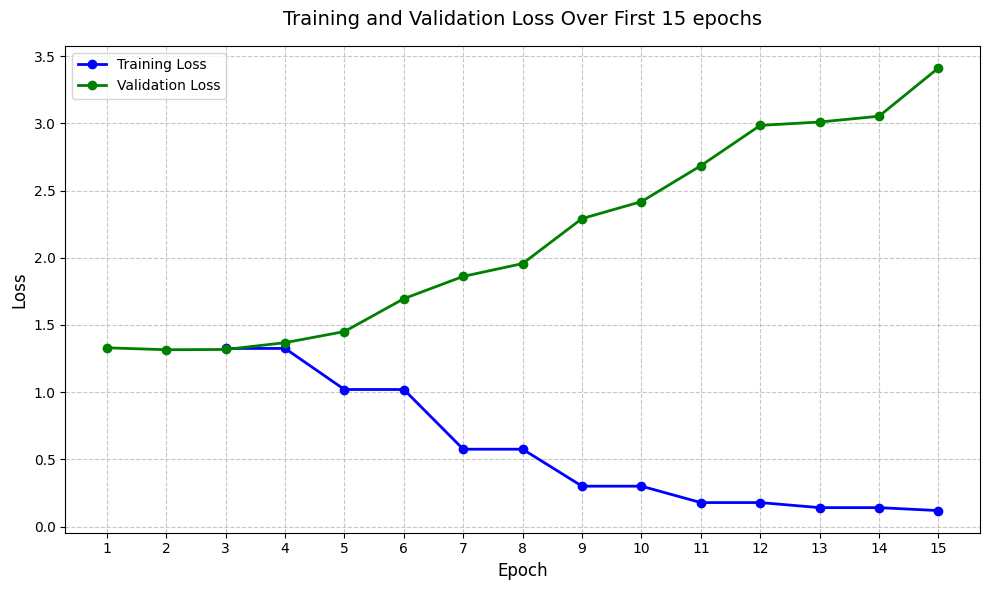

In [ ]:
# Training and validation loss plot from Pre-Trained model:

def plot_training_results(training_loss, validation_loss):

    epochs = range(1, len(validation_loss) + 1)

    plt.figure(figsize=(10, 6))

    plt.plot(epochs, training_loss, 'b-', label='Training Loss', linewidth=2, marker='o')
    plt.plot(epochs, validation_loss, 'g-', label='Validation Loss', linewidth=2, marker='o')

    plt.title('Training and Validation Loss Over First 15 epochs', fontsize=14, pad=15)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)

    plt.xticks(epochs)

    plt.tight_layout()
    plt.show()



training_loss = [None, None, 1.325300, 1.325300, 1.019700, 1.019700, 0.575400, 0.575400,
                0.300200, 0.300200, 0.178200, 0.178200, 0.140500, 0.140500, 0.118500]
validation_loss = [1.330019, 1.315711, 1.317649, 1.368218, 1.451076, 1.695514, 1.861595, 1.956876,
                  2.291768, 2.417999, 2.685175, 2.985337, 3.010504, 3.053506, 3.412729]

plot_training_results(training_loss, validation_loss)